# Постановка исследовательского вопроса

Целью любой коммерчиской организации является увеличение собственной прибыли за счет ведения основного вида деятельности. При определении сферы деятельности, целевой аудитории, ассортимента и прочих базовых принципов ведения бизнеса практически единственной переменной, которой может управлять фирма, является цена оказываемой услуги или продаваемого товара. При первичном установлении цены у любой фирмы нет точных данных о спросе на их продукцию, поэтому необходимо применять экспертный подход, основывающийся на общем представлении о спросе; а последующая корректировка цены, с целью ее оптимизации, возможна только на ретроспективных данных о фактических объемах продаж.

Одной из таких фирм является сеть розничных магазинов "Семья". Данная сеть организовала достаточно продвинутую систему сбора данных о продажах, благодаря которой возможно постраение большого множества моделей для совершенно различных задач.

Целью данного проекта является разработка модели оценки потребительсколго спроса, которая позволит дать рекомендации по оптимальному управлению ценой в сети магазинов "Семья".

# Описание исходных данных

Для проекта используются данные по продаже соков в сети магазинав "Семья" города Пермь. Доступ к базе данных был предоставлен лаборатории "GAMES" НИУ ВШЭ-Пермь представителями сети. В исходной базе данных собирается информация в различных разрезах: продажи определенных категорий товаров в конкретном магазине, информация о продажах по чекам, информация о покупках конкретных потребителей через систему карт лояльности и т.д. С целью конфиденциальности доступ ко всем данным предоставлялся только ограниченному кругу лиц, поэтому для учебных целей имеется только датасет по продажам соков в разрезе магазинов.

Данные имеют панельную структуру, где наблюдением является количество проданных единиц (упаковок) определенного sku в конкретном магазине за каждый день в период с 2009 по 2014 год.

В используемой базе данных имеются следующие характеристики соков: цена, объем, вкус, наличие мякоти, находился данный сок ли в акции в определенный день, материал упаковки.

# Подготовка данных

Загрузим необходимые пакеты и исходные данные.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score

semya_init = pd.read_stata('/Users/danil_kusakin/Desktop/semya_12_final.dta')

Предварительно посмотрим на то, как распределены объемы продаж в исходных данных.

In [2]:
semya_init.salesvolume.describe()

count    9.893705e+06
mean     7.796319e-01
std      4.506791e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      4.828000e+03
Name: salesvolume, dtype: float64

На данном этапе можно заметить, что как минимум половина наблюдений имеею нулевые продажи и как минимум 75% выборки – не более одной единицы. Такое распределение зависимой переменной вызвано излишней детализацией: продажи конкретного sku в конкретный день в определенном магазине. Уже из подобного анализа можно сказать, что на таких данных любая модель будет плохо работать, так как ей будет "удобно" давать тривиальный прогноз, где все продажи равны нулю или близки к этому значению.

Особенностью ценообразования сети "Семья" является установление единой цены для всех магазинов во всем городе, то есть неоправданно разбиение до уровня магазинов. Таким образом, является логичным агрегирование данных до уровня продаж конекретного sku в определенный день по всей сети.

Сделаем агрегацию данных от уровня отдельных магазинов до объемов продаж по всей сети.

In [3]:
semya_gb=semya_init.groupby(['id_sku', 'date2'])['salesvolume'].sum().reset_index()
semya_gb.head()

,id_sku,date2,salesvolume
0,10826,2009-01-01,2
1,10826,2009-01-02,2
2,10826,2009-01-03,1
3,10826,2009-01-04,2
4,10826,2009-01-05,2


Проведем грубый анализ на выбросы.

In [4]:
semya_gb.describe()

,id_sku,salesvolume
count,4.582740e+05,458274.000000
mean,4.122711e+05,16.831520
std,3.241129e+05,48.057349
min,1.082600e+04,0.000000
25%,2.917450e+05,2.000000
50%,4.376760e+05,6.000000
75%,4.685580e+05,14.000000
max,1.907577e+06,5766.000000


(array([4.50867e+05, 5.48400e+03, 1.21500e+03, 3.45000e+02, 1.75000e+02,
        9.70000e+01, 4.20000e+01, 2.40000e+01, 1.60000e+01, 3.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00]),
 array([   0.        ,  160.16666667,  320.33333333,  480.5       ,
         640.66666667,  800.83333333,  961.        , 1121.16666667,
        1281.33333333, 1441.5       , 1601.66666667, 1761.83333333,
        1922.        , 2082.16666667, 2242.33333333, 2402.5       ,
        2562.66666667, 2722.83333333, 2883.        , 3043.16666667,
        3203.33333333, 3363.5       , 3523.66666667, 3683.83333333,
        3844.        , 4004.16666667, 4164.33333333, 4324.

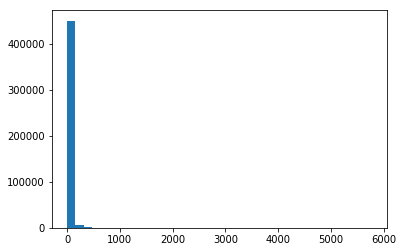

In [5]:
plt.hist(semya_gb['salesvolume'],bins = int(180/5))

Из описательных статистик и гистограммы видно, что есть крайне редкие аномально высокие продажи, однако большинсво наблюдений имеют относильно низкий объем продаж. Такие наблюдения могут являться техническими ошибками заполнения данных или же "особыми" днями, например большие праздники, которые не характерны в общем случае. Так или иначе, является логичным удаление таких наблюдений из выборки для уменьшения их отрицательного влияния на модели.

Путем постепенного отрезания по верхней границе продаж было выявленно, что разумной является граница в 100 единиц, так как бОльшие наблюдения встречаются крайне редко. После чего распределение продаж выглядит следующим образом.

(array([134436.,  74648.,  59811.,  30988.,  35637.,  25227.,  18064.,
          8987.,  10548.,   7847.,   5883.,   3240.,   4023.,   3274.,
          2751.,   1522.,   1987.,   1710.,   1440.,    858.,   1090.,
          1058.,    980.,    618.,    899.,    751.,    755.,    432.,
           620.,    596.,    573.,    373.,    562.,    534.,    491.,
           480.]),
 array([ 0.  ,  2.75,  5.5 ,  8.25, 11.  , 13.75, 16.5 , 19.25, 22.  ,
        24.75, 27.5 , 30.25, 33.  , 35.75, 38.5 , 41.25, 44.  , 46.75,
        49.5 , 52.25, 55.  , 57.75, 60.5 , 63.25, 66.  , 68.75, 71.5 ,
        74.25, 77.  , 79.75, 82.5 , 85.25, 88.  , 90.75, 93.5 , 96.25,
        99.  ]),
 <a list of 36 Patch objects>)

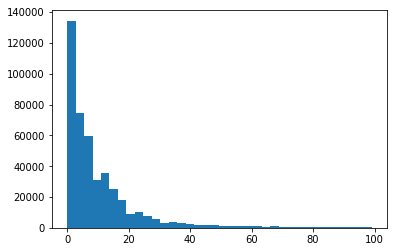

In [6]:
semya_gb=semya_gb[semya_gb.salesvolume < 100]
plt.hist(semya_gb['salesvolume'],bins = int(180/5))

Далее нам необходимо "присоединить" характеристики сока из исходной таблице к новой.

In [7]:
semya_ndub=semya_init.drop_duplicates(subset=['id_sku', 'date2'])
semya_new = pd.merge(semya_gb, semya_ndub,  how='left', on = ['id_sku','date2'])
semya_new.head()

,id_sku,date2,salesvolume_x,date,day,month,year,id_store,salesvolume_y,salessumm,...,applemix,mix,juicecontentreal,carton,pulp,city,format,revenue,cust_count,action2
0,10826,2009-01-01,2,2009-01-01,1,1,2009,43,1,71,...,0,1,100,1,0,Perm,Large,667749.0,8876.0,0
1,10826,2009-01-02,2,2009-01-02,2,1,2009,43,1,71,...,0,1,100,1,0,Perm,Large,1405083.0,21416.0,0
2,10826,2009-01-03,1,2009-01-03,3,1,2009,43,0,0,...,0,1,100,1,0,Perm,Large,1248222.0,20353.0,0
3,10826,2009-01-04,2,2009-01-04,4,1,2009,43,0,0,...,0,1,100,1,0,Perm,Large,1267606.0,21688.0,0
4,10826,2009-01-05,2,2009-01-05,5,1,2009,43,0,0,...,0,1,100,1,0,Perm,Large,1417431.0,23444.0,0


Теперь подготовим данные для более корректного моделирования.

Во-первых, сформируем переменную time которая будет отражать тренд с точностью до календарного месяца. Такая переменная позволит учесть изменения в средней потребительской корзине во времени. В качестве единице времени был выбран один месяц, потому что в "Семье" изменение цен происходит раз в две недели, то есть нет смысла дробить до конкретного дня; как правило в месяце больше четырех недель, поэтому сложно отловить конкретный день изменения цен, поэтому календарный месяц являться оптимальным выбором с точки зрения точности и простоты расчетов.

Так же разобьем переменную id_brand на дамми, так как эта переменная является категориальной и не может быть упрорядочена естественным образом; включение же дамми на бренд позволит учесть ненаблюдаемые характеристики качесва сока.

Удалим ненужные переменные для облегчения расчетов. Пропуски в данных не позволяют работать некоторым моделям, поэтому необходимо из чем-то заменить или удалить; в нашем случае даже после удаления мы имеем более 360 тыс. наблюдений, поэтому просто удалим пропуски.

In [8]:
semya_new['time']=(semya_new['year']-2009)*12+semya_new['month']

semya_dbrand = pd.get_dummies(semya_new['id_brand'])
semya = pd.concat([semya_new, semya_dbrand], axis=1)

semya=semya.drop(columns=['date2','date','day', 'month','year','id_store','salesvolume_y','salessumm',
                          'price','isaction','id_brand','sizereal','id_taste','juicecontentreal','city'
                          ,'format','revenue','cust_count'])

semya=semya.dropna()

cols = ['salesvolume_x']  + [col for col in semya if col != 'salesvolume_x']
semya = semya[cols]

semya.head()

,salesvolume_x,id_sku,av_price,size,sizecheatdummy,orange,apple,cherry,peachapricot,pineapple,...,2033,2035,2036,2040,2044,2046,2047,2048,2050,2051
0,2,10826,71.0,1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,10826,71.0,1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,10826,71.0,1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,10826,71.0,1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,10826,71.0,1000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Оценка моделей

Выделим зависимую и независимые переменные и разобьем выборку на тестовую и обучающую.

In [9]:
X = semya.iloc[:,1:].values
y = semya.iloc[:,0].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Выбор модели осуществлялся не из теоретических предпосылок и особенностей данных, а "в лоб" по предсказательной силе конкретной спецификации.

Модели типа adaboost имели крайне плохую предсказательную способность.

Модели gradient boosting имели лучшее качество. Эти модели имели возможность к дальнейшему улучшению путем увеличения количества итераций, однако с определенного момента сложность расчетов возрастала в разы, а прирост в качестве становился крайне мал. Из-за ограниченных возмозностей по улучшению модели она была отброшена.

Модель дерева решений имеет достаточно хорошее объясняющее и прогнозное качество при быстроте расчетов, а модель random forest позволяет дополнительно усилить силу прогноза.

Ансамбли по типу стэкинга и бэггинга не улучшали качество прогноза по сравнению с random forest, а лишь усложняли расчеты, поэтому было принято решение остановиться именно на модели случайного леса.

In [10]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor(n_estimators=20, max_features=25)
modelRF.fit(X_train, y_train)
modelRF.score(X_train, y_train), modelRF.score(X_test, y_test)

(0.8462108935982576, 0.7966204326679689)

Практическим путем было выяснено, что вариация параметров в данной модели не позволяет достичь стабильного прироста в качестве, поэтому остановимся на представленном варианте.

Интерпретация модели показывает, что в данном примере наиболее значимой является переменная цены, поэтому действительно для сети есть смысл управлять ценой.

Так же значимыми параметрами оказались объем, вкус и скидка, что соответствует логике о том, как люди выбирабт сок.

In [11]:
import eli5
feat_imp_tree = eli5.explain_weights_df(modelRF)
feat_imp_tree.head()

,feature,weight,std
0,x1,0.323778,0.025086
1,x18,0.185660,0.008608
2,x0,0.135081,0.025262
3,x2,0.040461,0.018188
4,x17,0.029436,0.010186


# Выявление эффекта изменения цены

Так как косвенно предполагаем, что ценовая политика направлена в будущее, то логично основываться именно на прогнозном качестве модели.

Прежде всего посмотрим, на общую схожесть прогноза и реальных данных.

Real data


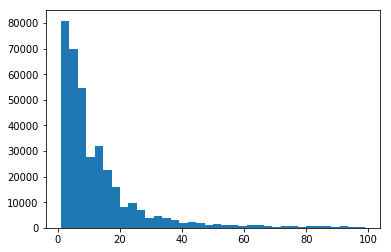

In [12]:
plt.hist(semya['salesvolume_x'],bins = int(180/5))
print('Real data')

Forecast


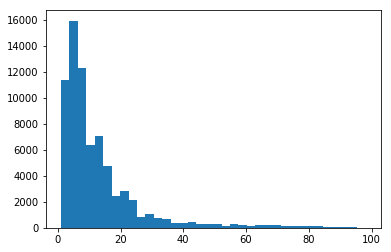

In [13]:
pred=modelRF.predict(X_test).round()

plt.hist(pred,bins = int(180/5))
print('Forecast')

Как можем заметить, наш прогноз достаточно хорошо описывает данные, что дает нам возможность для дальнейшей интерпретации.

Внесем изменения в цены и посмотрим эффект на некоторых примерах.

In [14]:
test_ex = X_test[123:130,:]
temp = test_ex.copy()
print('Реальные данные:', modelRF.predict(temp).round())
temp1= 0.8*test_ex.copy()
print('Уменьшаем цену:', modelRF.predict(temp1).round())
temp2= 1.3*test_ex.copy()
print('Увеличим цену:', modelRF.predict(temp2).round())

Реальные данные: [ 7.  1.  5. 12.  6.  8.  9.]
Уменьшаем цену: [ 8.  8.  8. 10. 27. 16. 15.]
Увеличим цену: [ 8.  4.  5.  4. 11.  9.  6.]


In [15]:
modelRF.predict(temp).round().mean(),modelRF.predict(temp1).round().mean(),modelRF.predict(temp2).round().mean()

(6.857142857142857, 13.142857142857142, 6.714285714285714)

Из данных примеров можно заметить, что прогноз продаж зависит от цены, притом эффект направлен в "нужную" сторону (знак при цене отрицательный, так как при увеличении цены продажи падают).

В качестве качества прогноза проверим среднюю выручку от продаж на конкретную дату.

In [16]:
temp3 = X_test.copy()
sale_sum_real=np.multiply(X_test[:,1],y_test)
sale_sum=np.multiply(temp3[:,1],modelRF.predict(temp3).round())
    
print('Real mean:', sale_sum_real.mean())

print('Predicted mean:', sale_sum.mean())

Real mean: 807.1978271333287
Predicted mean: 808.1673794952899


Как мы видим, в среднем модель предсказывает объем продаж достаточно точно, то есть магазинам можно опираться на результаты прогнозирования с целью управления ценой.

Далее вносились изменения во все цены путем их умножения на определенный коэффициент.
Опытным путем быво выявлено, что максимум выручки достигается при среднем понижении цены на 10% от исходной.

In [21]:
temp3= 0.9*X_test.copy()
sale_sum=np.multiply(temp3[:,1],modelRF.predict(temp3).round())
sale_sum.mean()

987.7487189713263

# Выводы

Результаты мини-исследования показали, что сети магазинов "Семья" в Перми оптимально понизить цены на сок в среднем на 10%. Выводы согласуются со здравым смыслом, так как цены в данной сети выше, чем у конкурентов (например, в Пятерочке)(из личного опыта и наблюдений), поэтому люди предпочитают сэкономить при покупке данного товара. Понижение же цен как раз позволило бы достигнуть уровня конкурентов и в полной мере бороться за покупателей.

В данном проекте не была произведена корректировка цены по каждому sku отдельно, так как качесво прогноза в 0.8 не позволяет делать качественный точный прогноз, и лишь давать обобщенные рекомендации.

Вместе с тем, сеть так же собирает данные по клиентам (через карты лояльности), поэтому существует возможность для дальнейшего улучшения модели и выработку более точных и конкретных решений (например, установление цен на месяц вперед, тогда в качестве тестовой выборке будут не случайные наблюдения, а продажи за последний месяц).

В целом, подход показал свою работоспособность, а полученные результаты полностью согласуются с общей логикой, поэтому цель проекта можно считать достигнутой.